<a href="https://colab.research.google.com/github/ssaltunel/STDP/blob/main/STDP_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Handwritten Digits Using Spiking Neural Networks on N-MNIST
## STDP
## BindsNet

### Using N-MNIST Dataset with Spiking Neural Networks (SNN)

This notebook demonstrates how to load, preprocess, and train a Spiking Neural Network (SNN) using the N-MNIST dataset in Google Colab. The N-MNIST dataset is a neuromorphic version of the classic MNIST dataset, designed for use with SNNs. Below are the detailed steps to achieve this.

Steps:
Download and Extract N-MNIST Dataset:
We download the dataset files from Google Drive and extract them for use.

Define a Custom Dataset Class:
We create a custom PyTorch Dataset class to handle the N-MNIST data format and load the data accordingly.

Transform and Encode Data:
We use a Poisson encoder to transform the images into spike trains suitable for SNNs.

Build and Train the SNN:
We define the SNN architecture using bindsnet, set up STDP learning rules, and train the network on the N-MNIST dataset.

# General description of the project
## Spiking Neural Networks (SNN):
SNNs are a special type of neural networks that simulate the behavior of biological neurons. These neurons send nerve signals in the form of discrete pulses (spike) and make decisions based on the timing of these pulses.

## STDP (Spike-Timing-Dependent Plasticity) algorithm:
This algorithm is one of the most important learning rules in SNN. STDP adjusts weight changes of synapses based on the time difference between presynaptic and postsynaptic neuron spikes. If the postsynaptic neuron spikes immediately after the presynaptic neuron, the weight of the synapse increases and vice versa.

## N-MNIST data:
N-MNIST is a dynamic version of the MNIST dataset designed to simulate spike-like visual inputs. These data were generated using an artificial eye called DVS (Dynamic Vision Sensor).

## BindsNet:
BindsNet is a Python library designed for simulating and learning SNNs. This tool allows you to easily create spiking neural networks and implement various learning algorithms.

Different models of spiking neurons are used to simulate the behavior of biological neurons. Each model processes neural inputs differently and simulates different behavior.

# 1. LIF (Leaky Integrate and Fire) model:
## General description:
The LIF model is one of the simplest and most widely used spiking neuron models. This model is mathematically simple, and because of this simplicity, it is very suitable for large-scale simulations and neural computations.

## Details:
**Integrate**: The membrane voltage of the neuron increases based on synaptic inputs (input spikes). Each synaptic input causes a momentary increase in voltage.
**Leaky**: The membrane voltage decreases over time to a baseline value (eg -70 mV). This decrease in voltage causes the neuron to gradually forget about the previous spikes.
**Fire**: When the membrane voltage reaches a threshold value (eg, -55 mV), the neuron "fires," i.e., produces a spike, and the membrane voltage returns to baseline.

## Mathematical formula:
The change in membrane voltage is as follows:
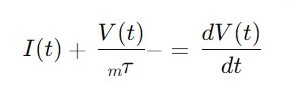

in which:

V(t) is membrane voltage at time t

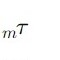The time constant is the leakage membrane voltage.
I(t) is the synaptic input current.

# 2. IF (Integrate and Fire) model:
## General description:
The IF model is a simpler version of the LIF in which the leakage effect is not present. This model only includes Integrate and Fire.

## Details:
In the IF model, the membrane voltage increases only by the sum of the synaptic inputs and there is no leakage. When the voltage reaches the threshold, the neuron fires and the voltage returns to baseline.

## Mathematical formula:
The change in membrane voltage is as follows:
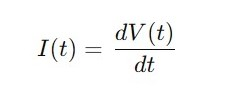

in which:

I(t) is the synaptic input current.



# Step 1: Install necessary libraries and packages

In [ ]:
!pip install bindsnet # stable version
!pip install gdown
!pip install git+https://github.com/BindsNET/bindsnet.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.3 MB/s eta 0:00:00
  Created wheel for bindsnet: filename=bindsnet-0.2.7-py3-none-any.whl size=81400 sha256=e1ff1b3b7bd4888c2ca6fb8fde4afe46a12da5941d9541aed0238cdd75efbad8
  Stored in directory: /root/.cache/pip/wheels/94/06/3c/ce96902a847c6a788c61ba6a27ab52a3bdc9e2405f702bac30
Successfully built bindsnet
  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-zpd76zxd
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-zpd76zxd
  Resolved https://github.com/BindsNET/bindsnet.git to commit 091153c0b3ed9c718bffc35d4adc87c77ba5dd58
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.5 MB/

In [ ]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bindsnet 0.3.2 requires numpy<3,>=2, but you have numpy 1.26.4 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.


In [ ]:
# Add here necessary libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gym
import gc
from gym import spaces
# Bindsnet needs to be installed
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre, MSTDP
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_weights, plot_voltages
from bindsnet.environment import Environment
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.environment import GymEnvironment


# parameters

In [ ]:
# Some general parameters (change as needed)
n_neurons = 200
time = 300  # Number of timesteps per sample
n_train = 1000  # Number of training samples
n_test = 100  # Number of test samples
update_interval = 300  # Update the network every 200 samples
n_epochs = 10

# Step 2: Download N-MNIST dataset

In [ ]:
# Download N-MNIST dataset from Google Drive
!gdown '1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-' -O Train.zip
!gdown '1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f' -O Test.zip
!unzip -oq Train.zip -d nmnist
!unzip -oq Test.zip -d nmnist


Downloading...
From (original): https://drive.google.com/uc?id=1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-
From (redirected): https://drive.google.com/uc?id=1f-GwPB4pv0vqd0BqVs4_NsVYB4UTjsc-&confirm=t&uuid=42a048ec-b372-4a35-9d01-fda8a1a0fd58
To: /content/Train.zip
100% 1.01G/1.01G [00:35<00:00, 28.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f
From (redirected): https://drive.google.com/uc?id=1HAyMnpJdF_kxQEiO64D3P0ygImAfeg9f&confirm=t&uuid=2b4fc680-a425-45de-aff6-64e3857a3cc5
To: /content/Test.zip
100% 170M/170M [00:05<00:00, 28.4MB/s]


# Step 3: Custom class definition for N-MNIST dataset
define a custom class to load and use this data

The part related to **data processing and converting them into input spikes** in our code is divided into two main parts:

**Loading event data (Event Data) and processing them**: This part is done in the NMNISTDataset class.
**Transforming event data into spiking neural network inputs**: This part is done when the network is running in the training loop.

## 1. Data processing in the NMNISTDataset class
This class is responsible for loading data from event files. The main processing of event data is done in the load_data method.


## 2. Transform event data into network inputs in the training loop
In the training loop, the event data obtained from the NMNISTDataset class are transformed into network inputs.

In [ ]:
class NMNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, num_samples=None, time=None,
                 flatten=False, separate_exh_inh=False, cumulative=False, lazy=False, update_interval=update_interval):
        self.root = root
        self.train = train
        self.transform = transform
        self.flatten = flatten
        self.separate_exh_inh = separate_exh_inh
        self.cumulative = cumulative
        self.lazy = lazy
        self.time = time
        self.data, self.labels = self.load_data(num_samples=num_samples, update_interval=update_interval)
        self.idx_order = np.random.permutation(len(self.data))

    def shuffle(self):
        """Shuffle the order of samples."""
        self.idx_order = np.random.permutation(len(self.data))

    def load_data(self, num_samples=None, update_interval=300):
        """Load the dataset from the specified directory and convert it to spike events."""
        if self.train:
            data_path = os.path.join(self.root, 'Train')
        else:
            data_path = os.path.join(self.root, 'Test')

        data = []
        labels = []
        max_time = 320000  # Maximum time step for events

        for label in range(10):
            label_path = os.path.join(data_path, str(label))
            print(f"Loading {'training' if self.train else 'testing'} data for label {label} from {label_path}")

            if num_samples and (num_samples // 10 < len(os.listdir(label_path))):
                data_files = np.random.choice(os.listdir(label_path), num_samples // 10, replace=False)
            else:
                data_files = os.listdir(label_path)

            for i, file in enumerate(tqdm(data_files)):
                if (i + 1) % update_interval == 0:
                    print(f"Loaded {i + 1}/{len(data_files)} files for label {label}")
                labels.append(label)
                file_path = os.path.join(label_path, file)
                file_data = np.fromfile(file_path, dtype=np.uint8)

                if self.lazy:
                    data.append(file_data)
                else:
                    file_data = file_data.reshape(-1, 5)
                    event_data = np.apply_along_axis(self._bytes_to_event, 1, file_data)
                    spikes = self._events_to_spikes(event_data, max_time)
                    data.append(spikes)
                    del spikes
                    del event_data

                del file_data
                gc.collect()

        return data, labels

    def _events_to_spikes(self, events, max_time=320000):
        """Convert event data to spike tensors."""
        if self.time is not None:
            spikes = torch.zeros((self.time, 2 if self.separate_exh_inh else 1, 34, 34))
            time_step = np.ceil(max_time / self.time)
        else:
            spikes = torch.zeros((max_time, 2 if self.separate_exh_inh else 1, 34, 34))

        for event in events:
            x = event[0]
            y = event[1]
            p = event[2]
            t = event[3]
            if self.time is not None:
                t = int(t / time_step)
            if self.separate_exh_inh:
                if self.cumulative:
                    spikes[t:, 1 if p else 0, y, x] = 1
                else:
                    spikes[t, 1 if p else 0, y, x] = 1
            else:
                if self.cumulative:
                    spikes[t:, 0, y, x] = p
                else:
                    spikes[t, 0, y, x] = p

        if self.flatten:
            spikes = spikes.view(self.time, *([2, -1] if self.separate_exh_inh else [-1]))

        return spikes

    def _bytes_to_event(self, bytes_data):
        """Convert a byte array to event data (x, y, polarity, time)."""
        bits = bin(int.from_bytes(bytes_data, byteorder='big'))[2:]
        bits = '0' * (40 - len(bits)) + bits
        x = int(bits[:8], 2)
        y = int(bits[8:16], 2)
        p = int(bits[16:17], 2)
        t = int(bits[17:], 2)
        event = np.array((np.uint8(x), np.uint8(y), np.bool_(p), np.uint32(t)))
        return event

    def __len__(self):
        """Return the number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Return the sample and label at the given index."""
        if self.lazy:
            file_data = self.data[self.idx_order[idx]].reshape(-1, 5)
            event_data = np.apply_along_axis(self._bytes_to_event, 1, file_data)
            sample = self._events_to_spikes(event_data)
        else:
            sample = self.data[self.idx_order[idx]]
        label = self.labels[self.idx_order[idx]]

        if self.transform:
            sample = self.transform(sample)

        return {'spikes': sample, 'label': label}


# Step 4: Review the data
To ensure that the data is loaded correctly and ready to be used in the model

In [ ]:
# Load training and test dataset with two channels (excitatory and inhibitory)
train_dataset = NMNISTDataset(root='nmnist', train=True, num_samples=n_train, time=time, separate_exh_inh=True)
test_dataset = NMNISTDataset(root='nmnist', train=False, num_samples=n_test, time=time, separate_exh_inh=True)


Loading training data for label 0 from nmnist/Train/0


100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Loading training data for label 1 from nmnist/Train/1


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Loading training data for label 2 from nmnist/Train/2


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


Loading training data for label 3 from nmnist/Train/3


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Loading training data for label 4 from nmnist/Train/4


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Loading training data for label 5 from nmnist/Train/5


100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Loading training data for label 6 from nmnist/Train/6


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


Loading training data for label 7 from nmnist/Train/7


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Loading training data for label 8 from nmnist/Train/8


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Loading training data for label 9 from nmnist/Train/9


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


Loading testing data for label 0 from nmnist/Test/0


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Loading testing data for label 1 from nmnist/Test/1


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Loading testing data for label 2 from nmnist/Test/2


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Loading testing data for label 3 from nmnist/Test/3


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Loading testing data for label 4 from nmnist/Test/4


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Loading testing data for label 5 from nmnist/Test/5


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Loading testing data for label 6 from nmnist/Test/6


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Loading testing data for label 7 from nmnist/Test/7


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Loading testing data for label 8 from nmnist/Test/8


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Loading testing data for label 9 from nmnist/Test/9


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


In [ ]:
# Check the distribution of the loaded data
def check_data(dataset):
    label_counts = {i: 0 for i in range(10)}  # Create a dictionary to count tags
    for i in range(len(dataset)):  # Scroll through the samples in the dataset
        sample = dataset[i]
        label = sample['label']
        label_counts[label] += 1
    print("Label distribution:", label_counts)

# Examining educational data
print("Checking training dataset:")
check_data(train_dataset)

# Examining test data
print("Checking testing dataset:")
check_data(test_dataset)

Checking training dataset:
Label distribution: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}
Checking testing dataset:
Label distribution: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}


# Step 5: Implement sample selection and display for STDP

In [ ]:
# Function to select a number of examples of each label in the dataset
def select_samples_by_label(dataset, num_samples_per_label=1):
    label_samples = {i: [] for i in range(10)}
    for i in range(len(dataset)):
        sample = dataset[i]
        label = sample['label']
        if len(label_samples[label]) < num_samples_per_label:
            label_samples[label].append(sample)
        if all(len(label_samples[l]) >= num_samples_per_label for l in range(10)):
            break
    return label_samples


# Step 6: Display the selected samples

In [ ]:
# Function to display selected samples from each label
def plot_samples(label_samples, time_window=300, flatten=False, separate_exh_inh=False):
    if separate_exh_inh:
        fig, axes = plt.subplots(3, len(label_samples.items()), figsize=(20, 6))
    else:
        fig, axes = plt.subplots(1, len(label_samples.items()), figsize=(20, 6))

    for label, samples in label_samples.items():
        for i, sample in enumerate(samples):
            spikes = sample['spikes']

            # Display spikes individually
            if separate_exh_inh:
                img_exh = np.zeros_like(spikes[0, 1].numpy())
                img_inh = np.zeros_like(spikes[0, 0].numpy())
                for t in range(spikes.shape[0]):
                    img_exh += spikes[t, 1].numpy() if spikes.size(1) > 1 else spikes[t, 0].numpy()
                    img_inh += spikes[t, 0].numpy()
            else:
                img = np.zeros_like(spikes[0, 0].numpy())
                for t in range(spikes.shape[0]):
                    img += spikes[t, 0].numpy()

            if flatten:
                if separate_exh_inh:
                    img_exh = img_exh.reshape(34, 34)
                    img_inh = img_inh.reshape(34, 34)
                else:
                    img = img.reshape(34, 34)

            if separate_exh_inh:
                axes[0, label].imshow(img_inh, cmap='viridis', interpolation='nearest')
                axes[0, label].set_title(f'Label: {label} (Inh)')
                axes[0, label].axis('off')
                axes[1, label].imshow(img_exh, cmap='viridis', interpolation='nearest')
                axes[1, label].set_title(f'Label: {label} (Exh)')
                axes[1, label].axis('off')
                axes[2, label].imshow(img_exh - img_inh, cmap='viridis', interpolation='nearest')
                axes[2, label].set_title(f'Label: {label} (Exh - Inh)')
                axes[2, label].axis('off')
            else:
                axes[label].imshow(img, cmap='viridis', interpolation='nearest')
                axes[label].set_title(f'Label: {label}')
                axes[label].axis('off')

    plt.show()


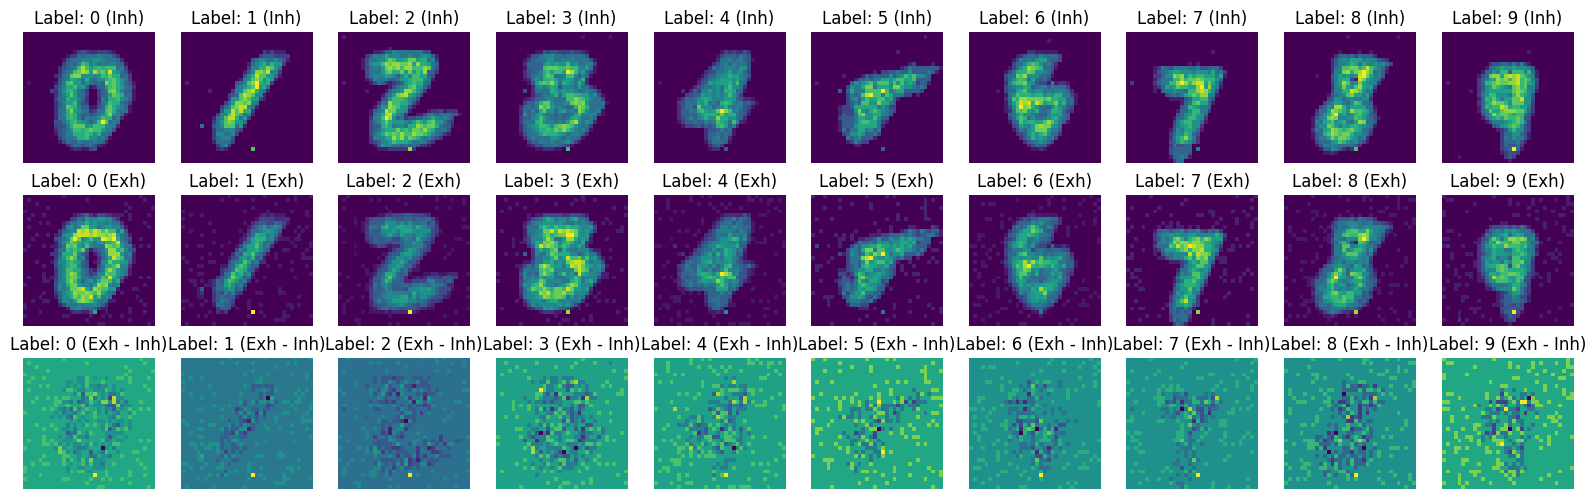

In [ ]:
# Selecting samples from the training dataset
train_label_samples = select_samples_by_label(train_dataset)

# Show spikes and samples with two channels
plot_samples(train_label_samples, flatten=True, separate_exh_inh=True)


# Step 7: Define the spiking neural network
First, we define a simple spiking neural network using neuronal layers and connections between them. In this network, we have two input layers for excitatory and inhibitory channels and one output layer.

In [ ]:
# Define the network
network = Network()

# Excitatory input layer
input_layer_exh = Input(n=34*34, traces=True)  # 34x34 neurons
# Inhibitory input layer
input_layer_inh = Input(n=34*34, traces=True)  # 34x34 neurons
# Output layer (number of neurons adjustable)
output_layer = LIFNodes(n=n_neurons, traces=True, thresh=-50.0)  # n_neurons in the output layer

# Add layers to the network
network.add_layer(input_layer_exh, name='exh')
network.add_layer(input_layer_inh, name='inh')
network.add_layer(output_layer, name='output')

# Connections between input and output layers
connection_exh = Connection(source=input_layer_exh, target=output_layer, w=0.05 + 0.1*torch.randn(input_layer_exh.n, output_layer.n))
connection_inh = Connection(source=input_layer_inh, target=output_layer, w=0.05 + 0.1*torch.randn(input_layer_inh.n, output_layer.n))

# Add connections to the network (without the learning rule)
network.add_connection(connection_exh, source='exh', target='output')
network.add_connection(connection_inh, source='inh', target='output')

# Define learning rules for excitatory and inhibitory connections
update_rule_exh = PostPre(connection_exh, nu=(5e-4, 5e-3))  # Learning rate for excitatory connection
update_rule_inh = PostPre(connection_inh, nu=(5e-4, 5e-3))  # Learning rate for inhibitory connection

# Apply the learning rules separately (not in add_connection)
connection_exh.update_rule = update_rule_exh
connection_inh.update_rule = update_rule_inh

# Monitor spikes and voltages
output_monitor = Monitor(obj=output_layer, state_vars=('s', 'v'), time=time)
network.add_monitor(output_monitor, name='output_spikes')

voltage_monitor = Monitor(obj=output_layer, state_vars=('v',), time=time)
network.add_monitor(voltage_monitor, name='voltages')

# Step 8: Network training with STDP
The spiky neural network is trained using the STDP algorithm. For this, we use the PostPre learning rule. After each step, we update the network and save the weights.

In [ ]:
# Create array to store spikes and voltages during training
spikes_record_output = torch.zeros(n_train, time, n_neurons)
voltages_record_output = torch.zeros(n_train, time, n_neurons)


# Start network training
for epoch in range(n_epochs):
    for i in tqdm(range(n_train)):
        inputs = {
          'exh': train_dataset[i]['spikes'][:, 1, :].view(time, -1),  # Excitatory channel (reshape)
          'inh': train_dataset[i]['spikes'][:, 0, :].view(time, -1),  # Inhibitory channel (reshape)
        }

        network.run(inputs=inputs, time=time)

        # Save spikes and voltages
        spikes_record_output[i] = output_monitor.get('s').view(time, -1)
        voltages_record_output[i] = output_monitor.get('v').view(time, -1)


        network.reset_state_variables()


 69%|██████▊   | 687/1000 [05:46<02:29,  2.09it/s]

# Step 9: Network Assessment
After completing the training, we run the network on the test set and evaluate the network output to check the final classification of handwritten digits.



In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Evaluate with F1 and Accuracy criteria

In [ ]:
network.train(False)

true_labels = []
predicted_labels = []

for i in range(n_test):
    inputs = {
        'exh': test_dataset[i]['spikes'][:, 1, :].view(time, -1),  # excitatory
        'inh': test_dataset[i]['spikes'][:, 0, :].view(time, -1),  # inhibitory
    }

    network.run(inputs=inputs, time=time)

    output_spikes = output_monitor.get('s').view(time, -1)

    spike_counts = torch.sum(output_spikes, dim=0)

    predicted_label = torch.argmax(spike_counts).item()

    true_labels.append(test_dataset[i]['label'])
    predicted_labels.append(predicted_label)

    network.reset_state_variables()

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-score (macro average): {f1:.2f}")
print(output_spikes)
print(spike_counts)


Accuracy: 13.00%
F1-score (macro average): 0.06
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([7, 6, 6, 7, 8, 7, 7, 7, 8, 8, 7, 7, 7, 6, 7, 7, 7, 7, 8, 8, 7, 7, 8, 6,
        6, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 6, 7,
        7, 6])


# Step 10: Display the final weights after training
In step 10, after training the network, we can display the final weights between different layers to further analyze how the network is performing. For this, we use the weights stored in the connections and display them graphically.

Final Weights: Excitatory to Output Layer


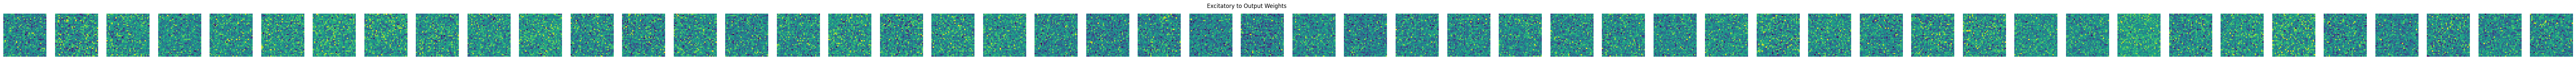

Final Weights: Inhibitory to Output Layer


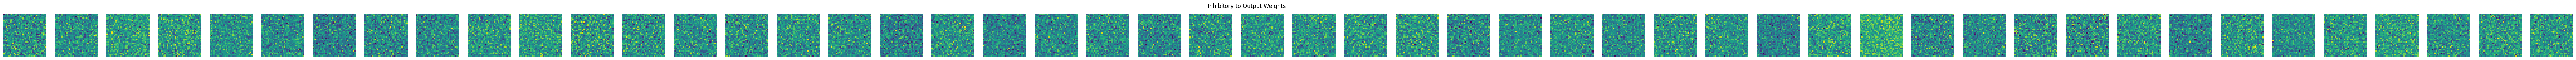

In [ ]:
def plot_weights(weights, n_neurons, input_shape=(34, 34), title="Weights"):
    """
    Display the final weights from the input layer to the output layer.

    weights: communication weights between layers.
    n_neurons: the number of neurons in the output layer.
    input_shape: input shape (for example 34x34).
    title: Chart title.
    """
    fig, axes = plt.subplots(1, n_neurons, figsize=(n_neurons * 2, 2))

    for i in range(n_neurons):
        weight_matrix = weights[:, i].view(*input_shape).detach().cpu().numpy()
        axes[i].imshow(weight_matrix, cmap="viridis", interpolation="nearest")
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()

print("Final Weights: Excitatory to Output Layer")
plot_weights(connection_exh.w, n_neurons=n_neurons, title="Excitatory to Output Weights")
#print(connection_exh.w)

print("Final Weights: Inhibitory to Output Layer")
plot_weights(connection_inh.w, n_neurons=n_neurons, title="Inhibitory to Output Weights")
#print(connection_exh.w)

# نمایش اسپایک‌های شبکه
plot_spikes({layer_name: monitor.get('s') for layer_name, monitor in network.monitors.items()})

# نمایش وزن‌های اتصالات excitatory و inhibitory
plot_weights(connection_exh.w, connection_inh.w)
